# Technical Indicators

## 0. Imports and Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os

### a. Import Data

In [2]:
data = pd.read_csv("cleaned_data-from 20211130 to 20231122-v02.csv")

In [3]:
data.head()

,Unnamed: 0,Adj Close-AAPL,Adj Close-AMZN,Adj Close-GOOG,Adj Close-META,Adj Close-MSFT,Adj Close-NVDA,Adj Close-TSLA,High-AAPL,High-AMZN,...,Open-MSFT,Open-NVDA,Open-TSLA,Volume-AAPL,Volume-AMZN,Volume-GOOG,Volume-META,Volume-MSFT,Volume-NVDA,Volume-TSLA
0,2021-11-30 14:30:00,164.0600,178.32797,145.95300,335.030,337.20,331.737,387.62332,164.22,179.28850,...,335.32,331.6900,381.45667,30227336.0,760036.0,219225.0,4263603.0,6570598.0,12885068.0,6562747.0
1,2021-11-30 15:30:00,163.1000,176.07700,144.25300,329.230,331.04,322.500,377.06665,164.58,178.55551,...,337.22,331.7250,387.76670,28373092.0,685434.0,174966.0,3818372.0,5500238.0,10079985.0,5269359.0
2,2021-11-30 16:30:00,163.4500,175.25551,143.41052,327.580,330.28,322.040,377.10498,163.68,176.40350,...,331.03,322.4805,376.84000,18461416.0,474069.0,168113.0,2485049.0,4107046.0,7347306.0,3247689.0
3,2021-11-30 17:30:00,163.7589,175.09103,142.94101,326.465,330.63,322.235,375.49840,164.26,175.72650,...,330.26,321.9500,376.96335,12421191.0,280328.0,130850.0,2303632.0,1937892.0,4808977.0,2089177.0
4,2021-11-30 18:30:00,164.5100,175.94950,143.61350,326.940,332.17,325.125,379.50668,164.92,176.21451,...,330.63,322.2250,375.51000,14607270.0,303796.0,122480.0,2015707.0,2078903.0,5883897.0,1840965.0


In [4]:
df = data.copy()

### b. Drop Nan Rows

In [5]:
def drop_nan_rows(df):
    """
    Drop all rows with NaN values from a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.

    Returns:
    - pd.DataFrame: DataFrame with NaN rows dropped.
    """
    # Drop rows with NaN values
    df = df.dropna()

    return df

In [6]:
df = drop_nan_rows(df)
df.head()

,Unnamed: 0,Adj Close-AAPL,Adj Close-AMZN,Adj Close-GOOG,Adj Close-META,Adj Close-MSFT,Adj Close-NVDA,Adj Close-TSLA,High-AAPL,High-AMZN,...,Open-MSFT,Open-NVDA,Open-TSLA,Volume-AAPL,Volume-AMZN,Volume-GOOG,Volume-META,Volume-MSFT,Volume-NVDA,Volume-TSLA
0,2021-11-30 14:30:00,164.0600,178.32797,145.95300,335.030,337.20,331.737,387.62332,164.22,179.28850,...,335.32,331.6900,381.45667,30227336.0,760036.0,219225.0,4263603.0,6570598.0,12885068.0,6562747.0
1,2021-11-30 15:30:00,163.1000,176.07700,144.25300,329.230,331.04,322.500,377.06665,164.58,178.55551,...,337.22,331.7250,387.76670,28373092.0,685434.0,174966.0,3818372.0,5500238.0,10079985.0,5269359.0
2,2021-11-30 16:30:00,163.4500,175.25551,143.41052,327.580,330.28,322.040,377.10498,163.68,176.40350,...,331.03,322.4805,376.84000,18461416.0,474069.0,168113.0,2485049.0,4107046.0,7347306.0,3247689.0
3,2021-11-30 17:30:00,163.7589,175.09103,142.94101,326.465,330.63,322.235,375.49840,164.26,175.72650,...,330.26,321.9500,376.96335,12421191.0,280328.0,130850.0,2303632.0,1937892.0,4808977.0,2089177.0
4,2021-11-30 18:30:00,164.5100,175.94950,143.61350,326.940,332.17,325.125,379.50668,164.92,176.21451,...,330.63,322.2250,375.51000,14607270.0,303796.0,122480.0,2015707.0,2078903.0,5883897.0,1840965.0


### c. Format

In [7]:
def data_formating(df, Date_column, Open_column, High_column, Low_column, Adj_Close_column, Volume_column):
    """
    Preprocess a DataFrame by renaming columns, setting columns to float64,
    dropping unnecessary columns, setting the 'date' column to datetime type,
    and setting the 'date' column as the index.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - define which columns of df refere to which price data

    Returns:
    - pd.DataFrame: Processed DataFrame.
    """
    # Step 1: Rename columns
    df = df.rename(columns={
        Date_column: 'Date',
        Open_column: 'Open',
        High_column: 'High',
        Low_column: 'Low',
        Adj_Close_column: 'Adj_Close',
        Volume_column: 'Volume',
    })

    # Step 2: Set columns to float64
    df = df.astype({'Open': 'float32', 'High': 'float32', 'Low': 'float32', 'Adj_Close': 'float32', 'Volume': 'float32'})

    # Step 3: Drop all other columns
    columns_to_keep = ['Date', 'Open', 'High', 'Low', 'Adj_Close', 'Volume']
    df = df[columns_to_keep]

    # Step 4: Set 'date' column to datetime type
    df['Date'] = pd.to_datetime(df['Date'], format='mixed')

    # Step 5: Set 'date' column as the index
    df.set_index('Date', inplace=True)

    return df
    

In [8]:
data.dtypes

Unnamed: 0         object
Adj Close-AAPL    float64
Adj Close-AMZN    float64
Adj Close-GOOG    float64
Adj Close-META    float64
Adj Close-MSFT    float64
Adj Close-NVDA    float64
Adj Close-TSLA    float64
High-AAPL         float64
High-AMZN         float64
High-GOOG         float64
High-META         float64
High-MSFT         float64
High-NVDA         float64
High-TSLA         float64
Low-AAPL          float64
Low-AMZN          float64
Low-GOOG          float64
Low-META          float64
Low-MSFT          float64
Low-NVDA          float64
Low-TSLA          float64
Open-AAPL         float64
Open-AMZN         float64
Open-GOOG         float64
Open-META         float64
Open-MSFT         float64
Open-NVDA         float64
Open-TSLA         float64
Volume-AAPL       float64
Volume-AMZN       float64
Volume-GOOG       float64
Volume-META       float64
Volume-MSFT       float64
Volume-NVDA       float64
Volume-TSLA       float64
dtype: object

In [9]:
df = data_formating(df, 'Unnamed: 0', 'Open-AAPL', 'High-AAPL', 'Low-AAPL', 'Adj Close-AAPL', 'Volume-AAPL')
df

,Open,High,Low,Adj_Close,Volume
Date,,,,,
2021-11-30 14:30:00,159.985001,164.220001,159.919998,164.059998,30227336.0
2021-11-30 15:30:00,164.059998,164.580002,161.839996,163.100006,28373092.0
2021-11-30 16:30:00,163.089996,163.679993,162.020004,163.449997,18461416.0
2021-11-30 17:30:00,163.449997,164.259995,163.065002,163.758896,12421191.0
2021-11-30 18:30:00,163.759995,164.919998,163.660004,164.509995,14607270.0
...,...,...,...,...,...
2023-11-22 19:30:00,191.639999,191.639999,190.824997,191.512497,3992146.0
2023-11-24 14:30:00,190.869995,190.899994,189.300003,189.460007,7873135.0
2023-11-24 15:30:00,189.470001,189.669998,189.250000,189.610001,4853829.0


In [10]:
df.dtypes

Open         float32
High         float32
Low          float32
Adj_Close    float32
Volume       float32
dtype: object

## 1. Description & Code

### A. Moving Average (MA(5) & MA(20))

In [11]:
def moving_averages(df, column_name='Adj_Close', window_sizes=[5, 20]):
    """
    Add Moving Averages (MA) columns to the DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which moving averages are calculated.
    - window_sizes (list): List of window sizes for moving averages. Default is [5, 20].

    Returns:
    - pd.DataFrame: DataFrame with added MA columns.
    """
    for window_size in window_sizes:
        ma_column_name = f'MA_{window_size}'
        df[ma_column_name] = df[column_name].rolling(window=window_size).mean()

    return df

In [12]:
moving_averages(df)

,Open,High,Low,Adj_Close,Volume,MA_5,MA_20
Date,,,,,,,
2021-11-30 14:30:00,159.985001,164.220001,159.919998,164.059998,30227336.0,NaN,NaN
2021-11-30 15:30:00,164.059998,164.580002,161.839996,163.100006,28373092.0,NaN,NaN
2021-11-30 16:30:00,163.089996,163.679993,162.020004,163.449997,18461416.0,NaN,NaN
2021-11-30 17:30:00,163.449997,164.259995,163.065002,163.758896,12421191.0,NaN,NaN
2021-11-30 18:30:00,163.759995,164.919998,163.660004,164.509995,14607270.0,163.775778,NaN
...,...,...,...,...,...,...,...
2023-11-22 19:30:00,191.639999,191.639999,190.824997,191.512497,3992146.0,191.745499,191.006319
2023-11-24 14:30:00,190.869995,190.899994,189.300003,189.460007,7873135.0,191.305499,190.992569
2023-11-24 15:30:00,189.470001,189.669998,189.250000,189.610001,4853829.0,190.844501,190.978669


### B. Bollinger Band (BB up & BB down)

In [13]:
def bollinger_bands(df, column_name='Adj_Close', window_size=20, num_std_dev=2):
    """
    Calculate Bollinger Bands for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which Bollinger Bands are calculated.
    - window_size (int): Window size for the moving average. Default is 20.
    - num_std_dev (int): Number of standard deviations for the upper and lower bands. Default is 2.

    Returns:
    - pd.DataFrame: DataFrame with added columns for Bollinger Bands (BB up, BB down).
    """
    # Calculate the rolling mean (middle band)
    df['MiddleBand'] = df[column_name].rolling(window=window_size).mean()

    # Calculate the rolling standard deviation
    df['StdDev'] = df[column_name].rolling(window=window_size).std()

    # Calculate Bollinger Bands
    df['BB_Up'] = df['MiddleBand'] + num_std_dev * df['StdDev']
    df['BB_Down'] = df['MiddleBand'] - num_std_dev * df['StdDev']

    # Drop intermediate columns
    df.drop(['MiddleBand', 'StdDev'], axis=1, inplace=True)

    return df

In [14]:
bollinger_bands(df)

,Open,High,Low,Adj_Close,Volume,MA_5,MA_20,BB_Up,BB_Down
Date,,,,,,,,,
2021-11-30 14:30:00,159.985001,164.220001,159.919998,164.059998,30227336.0,NaN,NaN,NaN,NaN
2021-11-30 15:30:00,164.059998,164.580002,161.839996,163.100006,28373092.0,NaN,NaN,NaN,NaN
2021-11-30 16:30:00,163.089996,163.679993,162.020004,163.449997,18461416.0,NaN,NaN,NaN,NaN
2021-11-30 17:30:00,163.449997,164.259995,163.065002,163.758896,12421191.0,NaN,NaN,NaN,NaN
2021-11-30 18:30:00,163.759995,164.919998,163.660004,164.509995,14607270.0,163.775778,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-11-22 19:30:00,191.639999,191.639999,190.824997,191.512497,3992146.0,191.745499,191.006319,192.568526,189.444111
2023-11-24 14:30:00,190.869995,190.899994,189.300003,189.460007,7873135.0,191.305499,190.992569,192.605894,189.379244
2023-11-24 15:30:00,189.470001,189.669998,189.250000,189.610001,4853829.0,190.844501,190.978669,192.636248,189.321090


### C. Relative Difference in the Percentage of the price (RDP(1))

In [15]:
def rdp(df, column_name='Adj_Close'):
    """
    Calculate Relative Difference in the Percentage of the price (RDP(1)) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which RDP(1) is calculated.

    Returns:
    - pd.DataFrame: DataFrame with an added column for RDP(1).
    """
    # Calculate RDP(1)
    df['RDP_1'] = df[column_name].pct_change() * 100

    return df

In [16]:
rdp(df)

,Open,High,Low,Adj_Close,Volume,MA_5,MA_20,BB_Up,BB_Down,RDP_1
Date,,,,,,,,,,
2021-11-30 14:30:00,159.985001,164.220001,159.919998,164.059998,30227336.0,NaN,NaN,NaN,NaN,NaN
2021-11-30 15:30:00,164.059998,164.580002,161.839996,163.100006,28373092.0,NaN,NaN,NaN,NaN,-0.585145
2021-11-30 16:30:00,163.089996,163.679993,162.020004,163.449997,18461416.0,NaN,NaN,NaN,NaN,0.214589
2021-11-30 17:30:00,163.449997,164.259995,163.065002,163.758896,12421191.0,NaN,NaN,NaN,NaN,0.188982
2021-11-30 18:30:00,163.759995,164.919998,163.660004,164.509995,14607270.0,163.775778,NaN,NaN,NaN,0.458658
...,...,...,...,...,...,...,...,...,...,...
2023-11-22 19:30:00,191.639999,191.639999,190.824997,191.512497,3992146.0,191.745499,191.006319,192.568526,189.444111,-0.063920
2023-11-24 14:30:00,190.869995,190.899994,189.300003,189.460007,7873135.0,191.305499,190.992569,192.605894,189.379244,-1.071727
2023-11-24 15:30:00,189.470001,189.669998,189.250000,189.610001,4853829.0,190.844501,190.978669,192.636248,189.321090,0.079167


### D. Bias Ratio (BIAS(6), BIAS(12) & BIAS(24))

In [17]:
def bias(df, column_name='Adj_Close', ma_windows=[6, 12, 24]):
    """
    Calculate Bias Ratios (BIAS) for specified moving average windows for a column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which BIAS is calculated.
    - ma_windows (list): List of moving average window sizes. Default is [6, 12, 24].

    Returns:
    - pd.DataFrame: DataFrame with added columns for BIAS(6), BIAS(12), and BIAS(24).
    """
    for window_size in ma_windows:
        ma_column_name = f'MA_{window_size}'
        bias_column_name = f'BIAS_{window_size}'

        # Calculate the moving average
        df[ma_column_name] = df[column_name].rolling(window=window_size).mean()

        # Calculate BIAS
        df[bias_column_name] = ((df[column_name] - df[ma_column_name]) / df[ma_column_name]) * 100

        # Drop intermediate columns
        df.drop(ma_column_name, axis=1, inplace=True)

    return df

In [18]:
bias(df)

,Open,High,Low,Adj_Close,Volume,MA_5,MA_20,BB_Up,BB_Down,RDP_1,BIAS_6,BIAS_12,BIAS_24
Date,,,,,,,,,,,,,
2021-11-30 14:30:00,159.985001,164.220001,159.919998,164.059998,30227336.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-30 15:30:00,164.059998,164.580002,161.839996,163.100006,28373092.0,NaN,NaN,NaN,NaN,-0.585145,NaN,NaN,NaN
2021-11-30 16:30:00,163.089996,163.679993,162.020004,163.449997,18461416.0,NaN,NaN,NaN,NaN,0.214589,NaN,NaN,NaN
2021-11-30 17:30:00,163.449997,164.259995,163.065002,163.758896,12421191.0,NaN,NaN,NaN,NaN,0.188982,NaN,NaN,NaN
2021-11-30 18:30:00,163.759995,164.919998,163.660004,164.509995,14607270.0,163.775778,NaN,NaN,NaN,0.458658,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-22 19:30:00,191.639999,191.639999,190.824997,191.512497,3992146.0,191.745499,191.006319,192.568526,189.444111,-0.063920,-0.137662,0.251987,0.417054
2023-11-24 14:30:00,190.869995,190.899994,189.300003,189.460007,7873135.0,191.305499,190.992569,192.605894,189.379244,-1.071727,-0.995261,-0.784029,-0.656538
2023-11-24 15:30:00,189.470001,189.669998,189.250000,189.610001,4853829.0,190.844501,190.978669,192.636248,189.321090,0.079167,-0.739658,-0.691092,-0.590018


### E. Relative Strength Index (RSI)

In [19]:
def rsi(df, column_name='Adj_Close', window=14):
    """
    Calculate the Relative Strength Index (RSI) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which RSI is calculated. Default is 'Close'.
    - window (int): Window size for RSI calculation. Default is 14.

    Returns:
    - pd.DataFrame: DataFrame with an added column for RSI.
    """
    # Calculate daily price changes
    df['PriceChange'] = df[column_name].diff()

    # Calculate the average gain and average loss over the specified window
    df['Gain'] = df['PriceChange'].apply(lambda x: x if x > 0 else 0).rolling(window=window, min_periods=1).mean()
    df['Loss'] = -df['PriceChange'].apply(lambda x: x if x < 0 else 0).rolling(window=window, min_periods=1).mean()

    # Calculate relative strength (RS)
    df['RS'] = df['Gain'] / df['Loss']

    # Calculate RSI
    df['RSI'] = 100 - (100 / (1 + df['RS']))

    # Drop intermediate columns
    df.drop(['PriceChange', 'Gain', 'Loss', 'RS'], axis=1, inplace=True)

    return df

In [20]:
rsi(df)

,Open,High,Low,Adj_Close,Volume,MA_5,MA_20,BB_Up,BB_Down,RDP_1,BIAS_6,BIAS_12,BIAS_24,RSI
Date,,,,,,,,,,,,,,
2021-11-30 14:30:00,159.985001,164.220001,159.919998,164.059998,30227336.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-30 15:30:00,164.059998,164.580002,161.839996,163.100006,28373092.0,NaN,NaN,NaN,NaN,-0.585145,NaN,NaN,NaN,0.000000
2021-11-30 16:30:00,163.089996,163.679993,162.020004,163.449997,18461416.0,NaN,NaN,NaN,NaN,0.214589,NaN,NaN,NaN,26.717219
2021-11-30 17:30:00,163.449997,164.259995,163.065002,163.758896,12421191.0,NaN,NaN,NaN,NaN,0.188982,NaN,NaN,NaN,40.700316
2021-11-30 18:30:00,163.759995,164.919998,163.660004,164.509995,14607270.0,163.775778,NaN,NaN,NaN,0.458658,NaN,NaN,NaN,59.493687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-22 19:30:00,191.639999,191.639999,190.824997,191.512497,3992146.0,191.745499,191.006319,192.568526,189.444111,-0.063920,-0.137662,0.251987,0.417054,49.030432
2023-11-24 14:30:00,190.869995,190.899994,189.300003,189.460007,7873135.0,191.305499,190.992569,192.605894,189.379244,-1.071727,-0.995261,-0.784029,-0.656538,36.708838
2023-11-24 15:30:00,189.470001,189.669998,189.250000,189.610001,4853829.0,190.844501,190.978669,192.636248,189.321090,0.079167,-0.739658,-0.691092,-0.590018,34.988056


### F. Exponential Moving Average (EMA(12) & EMA(26))

In [21]:
def ema(df, column_name='Adj_Close', ema_short=12, ema_long=26):
    """
    Calculate Exponential Moving Averages (EMA) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which EMA is calculated. Default is 'Close'.
    - ema_short (int): Short-term EMA window size. Default is 12.
    - ema_long (int): Long-term EMA window size. Default is 26.

    Returns:
    - pd.DataFrame: DataFrame with added columns for EMA(12) and EMA(26).
    """
    # Calculate EMA(12)
    df['EMA_12'] = df[column_name].ewm(span=ema_short, adjust=False).mean()

    # Calculate EMA(26)
    df['EMA_26'] = df[column_name].ewm(span=ema_long, adjust=False).mean()

    return df

In [22]:
ema(df)

,Open,High,Low,Adj_Close,Volume,MA_5,MA_20,BB_Up,BB_Down,RDP_1,BIAS_6,BIAS_12,BIAS_24,RSI,EMA_12,EMA_26
Date,,,,,,,,,,,,,,,,
2021-11-30 14:30:00,159.985001,164.220001,159.919998,164.059998,30227336.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,164.059998,164.059998
2021-11-30 15:30:00,164.059998,164.580002,161.839996,163.100006,28373092.0,NaN,NaN,NaN,NaN,-0.585145,NaN,NaN,NaN,0.000000,163.912307,163.988887
2021-11-30 16:30:00,163.089996,163.679993,162.020004,163.449997,18461416.0,NaN,NaN,NaN,NaN,0.214589,NaN,NaN,NaN,26.717219,163.841182,163.948969
2021-11-30 17:30:00,163.449997,164.259995,163.065002,163.758896,12421191.0,NaN,NaN,NaN,NaN,0.188982,NaN,NaN,NaN,40.700316,163.828523,163.934890
2021-11-30 18:30:00,163.759995,164.919998,163.660004,164.509995,14607270.0,163.775778,NaN,NaN,NaN,0.458658,NaN,NaN,NaN,59.493687,163.933364,163.977490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-22 19:30:00,191.639999,191.639999,190.824997,191.512497,3992146.0,191.745499,191.006319,192.568526,189.444111,-0.063920,-0.137662,0.251987,0.417054,49.030432,191.268814,190.481009
2023-11-24 14:30:00,190.869995,190.899994,189.300003,189.460007,7873135.0,191.305499,190.992569,192.605894,189.379244,-1.071727,-0.995261,-0.784029,-0.656538,36.708838,190.990536,190.405379
2023-11-24 15:30:00,189.470001,189.669998,189.250000,189.610001,4853829.0,190.844501,190.978669,192.636248,189.321090,0.079167,-0.739658,-0.691092,-0.590018,34.988056,190.778146,190.346462


### G. Moving Average Convergence/Divergence (MACD)

In [23]:
def macd(df, column_name='Adj_Close', ema_short=12, ema_long=26, signal_period=9):
    """
    Calculate Moving Average Convergence Divergence (MACD) and its signal line for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which MACD is calculated. Default is 'Close'.
    - ema_short (int): Short-term EMA window size. Default is 12.
    - ema_long (int): Long-term EMA window size. Default is 26.
    - signal_period (int): Signal line EMA window size. Default is 9.

    Returns:
    - pd.DataFrame: DataFrame with added columns for MACD, Signal Line, and MACD Histogram.
    """
    # Calculate short-term EMA
    df['EMA_short'] = df[column_name].ewm(span=ema_short, adjust=False).mean()

    # Calculate long-term EMA
    df['EMA_long'] = df[column_name].ewm(span=ema_long, adjust=False).mean()

    # Calculate MACD Line
    df['DIF'] = df['EMA_short'] - df['EMA_long']

    # Calculate Signal Line
    df['Signal_Line'] = df['DIF'].ewm(span=signal_period, adjust=False).mean()

    # Calculate MACD Histogram
    df['OSC'] = df['DIF'] - df['Signal_Line']

    # Drop intermediate columns
    df.drop(['EMA_short', 'EMA_long'], axis=1, inplace=True)

    return df

In [24]:
macd(df)

,Open,High,Low,Adj_Close,Volume,MA_5,MA_20,BB_Up,BB_Down,RDP_1,BIAS_6,BIAS_12,BIAS_24,RSI,EMA_12,EMA_26,DIF,Signal_Line,OSC
Date,,,,,,,,,,,,,,,,,,,
2021-11-30 14:30:00,159.985001,164.220001,159.919998,164.059998,30227336.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,164.059998,164.059998,0.000000,0.000000,0.000000
2021-11-30 15:30:00,164.059998,164.580002,161.839996,163.100006,28373092.0,NaN,NaN,NaN,NaN,-0.585145,NaN,NaN,NaN,0.000000,163.912307,163.988887,-0.076581,-0.015316,-0.061264
2021-11-30 16:30:00,163.089996,163.679993,162.020004,163.449997,18461416.0,NaN,NaN,NaN,NaN,0.214589,NaN,NaN,NaN,26.717219,163.841182,163.948969,-0.107787,-0.033810,-0.073977
2021-11-30 17:30:00,163.449997,164.259995,163.065002,163.758896,12421191.0,NaN,NaN,NaN,NaN,0.188982,NaN,NaN,NaN,40.700316,163.828523,163.934890,-0.106367,-0.048322,-0.058045
2021-11-30 18:30:00,163.759995,164.919998,163.660004,164.509995,14607270.0,163.775778,NaN,NaN,NaN,0.458658,NaN,NaN,NaN,59.493687,163.933364,163.977490,-0.044126,-0.047483,0.003357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-22 19:30:00,191.639999,191.639999,190.824997,191.512497,3992146.0,191.745499,191.006319,192.568526,189.444111,-0.063920,-0.137662,0.251987,0.417054,49.030432,191.268814,190.481009,0.787806,0.847543,-0.059738
2023-11-24 14:30:00,190.869995,190.899994,189.300003,189.460007,7873135.0,191.305499,190.992569,192.605894,189.379244,-1.071727,-0.995261,-0.784029,-0.656538,36.708838,190.990536,190.405379,0.585157,0.795066,-0.209909
2023-11-24 15:30:00,189.470001,189.669998,189.250000,189.610001,4853829.0,190.844501,190.978669,192.636248,189.321090,0.079167,-0.739658,-0.691092,-0.590018,34.988056,190.778146,190.346462,0.431684,0.722390,-0.290706


### H. Psychological Line (PSY(12) & PSY(24))

In [25]:
def psy(df, column_name='Adj_Close', psy_short=12, psy_long=24):
    """
    Calculate Psychological Line (PSY) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which PSY is calculated. Default is 'Close'.
    - psy_short (int): Short-term PSY window size. Default is 12.
    - psy_long (int): Long-term PSY window size. Default is 24.

    Returns:
    - pd.DataFrame: DataFrame with added columns for PSY(12) and PSY(24).
    """
    # Calculate the percentage of days where the closing price is higher than the previous day's closing price
    df['PriceUp'] = df[column_name].diff() > 0

    # Calculate PSY(12)
    df['PSY_12'] = df['PriceUp'].rolling(window=psy_short).mean() * 100

    # Calculate PSY(24)
    df['PSY_24'] = df['PriceUp'].rolling(window=psy_long).mean() * 100

    # Drop intermediate columns
    df.drop(['PriceUp'], axis=1, inplace=True)

    return df

In [26]:
psy(df)

,Open,High,Low,Adj_Close,Volume,MA_5,MA_20,BB_Up,BB_Down,RDP_1,...,BIAS_12,BIAS_24,RSI,EMA_12,EMA_26,DIF,Signal_Line,OSC,PSY_12,PSY_24
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-30 14:30:00,159.985001,164.220001,159.919998,164.059998,30227336.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,164.059998,164.059998,0.000000,0.000000,0.000000,NaN,NaN
2021-11-30 15:30:00,164.059998,164.580002,161.839996,163.100006,28373092.0,NaN,NaN,NaN,NaN,-0.585145,...,NaN,NaN,0.000000,163.912307,163.988887,-0.076581,-0.015316,-0.061264,NaN,NaN
2021-11-30 16:30:00,163.089996,163.679993,162.020004,163.449997,18461416.0,NaN,NaN,NaN,NaN,0.214589,...,NaN,NaN,26.717219,163.841182,163.948969,-0.107787,-0.033810,-0.073977,NaN,NaN
2021-11-30 17:30:00,163.449997,164.259995,163.065002,163.758896,12421191.0,NaN,NaN,NaN,NaN,0.188982,...,NaN,NaN,40.700316,163.828523,163.934890,-0.106367,-0.048322,-0.058045,NaN,NaN
2021-11-30 18:30:00,163.759995,164.919998,163.660004,164.509995,14607270.0,163.775778,NaN,NaN,NaN,0.458658,...,NaN,NaN,59.493687,163.933364,163.977490,-0.044126,-0.047483,0.003357,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-22 19:30:00,191.639999,191.639999,190.824997,191.512497,3992146.0,191.745499,191.006319,192.568526,189.444111,-0.063920,...,0.251987,0.417054,49.030432,191.268814,190.481009,0.787806,0.847543,-0.059738,50.000000,62.500000
2023-11-24 14:30:00,190.869995,190.899994,189.300003,189.460007,7873135.0,191.305499,190.992569,192.605894,189.379244,-1.071727,...,-0.784029,-0.656538,36.708838,190.990536,190.405379,0.585157,0.795066,-0.209909,50.000000,58.333333
2023-11-24 15:30:00,189.470001,189.669998,189.250000,189.610001,4853829.0,190.844501,190.978669,192.636248,189.321090,0.079167,...,-0.691092,-0.590018,34.988056,190.778146,190.346462,0.431684,0.722390,-0.290706,58.333333,62.500000


### I. Williams %R (WMS%R)

In [27]:
def williams_percent_r(df, high_column='High', low_column='Low', adj_close_column='Adj_Close', window=14):
    """
    Calculate Williams %R for a specified high, low, and close columns in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - high_column (str): Name of the column containing high prices. Default is 'High'.
    - low_column (str): Name of the column containing low prices. Default is 'Low'.
    - adj_close_column (str): Name of the column containing close prices. Default is 'Close'.
    - window (int): Window size for Williams %R calculation. Default is 14.

    Returns:
    - pd.DataFrame: DataFrame with an added column for Williams %R.
    """
    # Calculate highest high and lowest low over the specified window
    df['HH'] = df[high_column].rolling(window=window).max()
    df['LL'] = df[low_column].rolling(window=window).min()

    # Calculate Williams %R
    df['Williams_%R'] = (df['HH'] - df[adj_close_column]) / (df['HH'] - df['LL']) * -100

    # Drop intermediate columns
    df.drop(['HH', 'LL'], axis=1, inplace=True)

    return df

In [28]:
williams_percent_r(df)

,Open,High,Low,Adj_Close,Volume,MA_5,MA_20,BB_Up,BB_Down,RDP_1,...,BIAS_24,RSI,EMA_12,EMA_26,DIF,Signal_Line,OSC,PSY_12,PSY_24,Williams_%R
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-30 14:30:00,159.985001,164.220001,159.919998,164.059998,30227336.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,164.059998,164.059998,0.000000,0.000000,0.000000,NaN,NaN,NaN
2021-11-30 15:30:00,164.059998,164.580002,161.839996,163.100006,28373092.0,NaN,NaN,NaN,NaN,-0.585145,...,NaN,0.000000,163.912307,163.988887,-0.076581,-0.015316,-0.061264,NaN,NaN,NaN
2021-11-30 16:30:00,163.089996,163.679993,162.020004,163.449997,18461416.0,NaN,NaN,NaN,NaN,0.214589,...,NaN,26.717219,163.841182,163.948969,-0.107787,-0.033810,-0.073977,NaN,NaN,NaN
2021-11-30 17:30:00,163.449997,164.259995,163.065002,163.758896,12421191.0,NaN,NaN,NaN,NaN,0.188982,...,NaN,40.700316,163.828523,163.934890,-0.106367,-0.048322,-0.058045,NaN,NaN,NaN
2021-11-30 18:30:00,163.759995,164.919998,163.660004,164.509995,14607270.0,163.775778,NaN,NaN,NaN,0.458658,...,NaN,59.493687,163.933364,163.977490,-0.044126,-0.047483,0.003357,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-22 19:30:00,191.639999,191.639999,190.824997,191.512497,3992146.0,191.745499,191.006319,192.568526,189.444111,-0.063920,...,0.417054,49.030432,191.268814,190.481009,0.787806,0.847543,-0.059738,50.000000,62.500000,-44.435781
2023-11-24 14:30:00,190.869995,190.899994,189.300003,189.460007,7873135.0,191.305499,190.992569,192.605894,189.379244,-1.071727,...,-0.656538,36.708838,190.990536,190.405379,0.585157,0.795066,-0.209909,50.000000,58.333333,-95.592173
2023-11-24 15:30:00,189.470001,189.669998,189.250000,189.610001,4853829.0,190.844501,190.978669,192.636248,189.321090,0.079167,...,-0.590018,34.988056,190.778146,190.346462,0.431684,0.722390,-0.290706,58.333333,62.500000,-90.217355


### J. Stochastic Oscillator (Stochastic%K & Stochastic%D)

In [29]:
def stochastic_oscillator(df, high_column='High', low_column='Low', adj_close_column='Adj_Close', k_window=14, d_window=3):
    """
    Calculate Stochastic Oscillator (%K and %D) for specified high, low, and close columns in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - high_column (str): Name of the column containing high prices. Default is 'High'.
    - low_column (str): Name of the column containing low prices. Default is 'Low'.
    - close_column (str): Name of the column containing close prices. Default is 'Close'.
    - k_window (int): Window size for %K calculation. Default is 14.
    - d_window (int): Window size for %D calculation. Default is 3.

    Returns:
    - pd.DataFrame: DataFrame with added columns for Stochastic %K and %D.
    """
    # Calculate lowest low and highest high over the specified window
    df['LL'] = df[low_column].rolling(window=k_window).min()
    df['HH'] = df[high_column].rolling(window=k_window).max()

    # Calculate Stochastic %K
    df['Stochastic_%K'] = ((df[adj_close_column] - df['LL']) / (df['HH'] - df['LL'])) * 100

    # Calculate Stochastic %D (3-day simple moving average of %K)
    df['Stochastic_%D'] = df['Stochastic_%K'].rolling(window=d_window).mean()

    # Drop intermediate columns
    df.drop(['LL', 'HH'], axis=1, inplace=True)

    return df

In [30]:
stochastic_oscillator(df)

,Open,High,Low,Adj_Close,Volume,MA_5,MA_20,BB_Up,BB_Down,RDP_1,...,EMA_12,EMA_26,DIF,Signal_Line,OSC,PSY_12,PSY_24,Williams_%R,Stochastic_%K,Stochastic_%D
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-30 14:30:00,159.985001,164.220001,159.919998,164.059998,30227336.0,NaN,NaN,NaN,NaN,NaN,...,164.059998,164.059998,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
2021-11-30 15:30:00,164.059998,164.580002,161.839996,163.100006,28373092.0,NaN,NaN,NaN,NaN,-0.585145,...,163.912307,163.988887,-0.076581,-0.015316,-0.061264,NaN,NaN,NaN,NaN,NaN
2021-11-30 16:30:00,163.089996,163.679993,162.020004,163.449997,18461416.0,NaN,NaN,NaN,NaN,0.214589,...,163.841182,163.948969,-0.107787,-0.033810,-0.073977,NaN,NaN,NaN,NaN,NaN
2021-11-30 17:30:00,163.449997,164.259995,163.065002,163.758896,12421191.0,NaN,NaN,NaN,NaN,0.188982,...,163.828523,163.934890,-0.106367,-0.048322,-0.058045,NaN,NaN,NaN,NaN,NaN
2021-11-30 18:30:00,163.759995,164.919998,163.660004,164.509995,14607270.0,163.775778,NaN,NaN,NaN,0.458658,...,163.933364,163.977490,-0.044126,-0.047483,0.003357,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-22 19:30:00,191.639999,191.639999,190.824997,191.512497,3992146.0,191.745499,191.006319,192.568526,189.444111,-0.063920,...,191.268814,190.481009,0.787806,0.847543,-0.059738,50.000000,62.500000,-44.435781,55.564219,61.990634
2023-11-24 14:30:00,190.869995,190.899994,189.300003,189.460007,7873135.0,191.305499,190.992569,192.605894,189.379244,-1.071727,...,190.990536,190.405379,0.585157,0.795066,-0.209909,50.000000,58.333333,-95.592173,4.407827,39.792110
2023-11-24 15:30:00,189.470001,189.669998,189.250000,189.610001,4853829.0,190.844501,190.978669,192.636248,189.321090,0.079167,...,190.778146,190.346462,0.431684,0.722390,-0.290706,58.333333,62.500000,-90.217355,9.782645,23.251563


### K. Percentage of Price Change (PROC)

In [31]:
def proc(df, column_name='Adj_Close', window=1):
    """
    Calculate Percentage of Price Change (PROC) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which PROC is calculated. Default is 'Close'.
    - window (int): Window size for PROC calculation. Default is 1.

    Returns:
    - pd.DataFrame: DataFrame with an added column for PROC.
    """
    # Calculate the percentage change in price using rolling window
    df['PROC'] = df[column_name].pct_change().rolling(window=window).mean() * 100

    return df

In [32]:
proc(df)
df.head(25)

,Open,High,Low,Adj_Close,Volume,MA_5,MA_20,BB_Up,BB_Down,RDP_1,...,EMA_26,DIF,Signal_Line,OSC,PSY_12,PSY_24,Williams_%R,Stochastic_%K,Stochastic_%D,PROC
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-30 14:30:00,159.985001,164.220001,159.919998,164.059998,30227336.0,NaN,NaN,NaN,NaN,NaN,...,164.059998,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-30 15:30:00,164.059998,164.580002,161.839996,163.100006,28373092.0,NaN,NaN,NaN,NaN,-0.585145,...,163.988887,-0.076581,-0.015316,-0.061264,NaN,NaN,NaN,NaN,NaN,-0.585145
2021-11-30 16:30:00,163.089996,163.679993,162.020004,163.449997,18461416.0,NaN,NaN,NaN,NaN,0.214589,...,163.948969,-0.107787,-0.033810,-0.073977,NaN,NaN,NaN,NaN,NaN,0.214589
2021-11-30 17:30:00,163.449997,164.259995,163.065002,163.758896,12421191.0,NaN,NaN,NaN,NaN,0.188982,...,163.934890,-0.106367,-0.048322,-0.058045,NaN,NaN,NaN,NaN,NaN,0.188982
2021-11-30 18:30:00,163.759995,164.919998,163.660004,164.509995,14607270.0,163.775778,NaN,NaN,NaN,0.458658,...,163.977490,-0.044126,-0.047483,0.003357,NaN,NaN,NaN,NaN,NaN,0.458658
2021-11-30 19:30:00,164.520004,164.860001,163.429993,163.509995,15455717.0,163.665778,NaN,NaN,NaN,-0.607866,...,163.942861,-0.074630,-0.052912,-0.021718,NaN,NaN,NaN,NaN,NaN,-0.607866
2021-12-01 14:30:00,166.839996,168.449997,166.089996,167.619995,35887632.0,164.569775,NaN,NaN,NaN,2.513611,...,164.215241,0.230184,0.003707,0.226477,NaN,NaN,NaN,NaN,NaN,2.513611
2021-12-01 15:30:00,167.619995,170.199997,167.610001,169.844803,23651424.0,165.848737,NaN,NaN,NaN,1.327288,...,164.632246,0.643853,0.131736,0.512117,NaN,NaN,NaN,NaN,NaN,1.327288
2021-12-01 16:30:00,169.850006,170.009995,169.079895,169.899994,14995901.0,167.076956,NaN,NaN,NaN,0.032496,...,165.022449,0.965018,0.298393,0.666625,NaN,NaN,NaN,NaN,NaN,0.032496


### L. Momentum (MO(1))

In [33]:
def momentum(df, column_name='Adj_Close', window=1):
    """
    Calculate Momentum (MO) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which Momentum is calculated. Default is 'Close'.
    - window (int): Window size for Momentum calculation. Default is 1.

    Returns:
    - pd.DataFrame: DataFrame with an added column for Momentum.
    """
    # Calculate the difference in price over the specified window
    df['Momentum'] = df[column_name].diff(window)

    return df

In [34]:
momentum(df)

,Open,High,Low,Adj_Close,Volume,MA_5,MA_20,BB_Up,BB_Down,RDP_1,...,DIF,Signal_Line,OSC,PSY_12,PSY_24,Williams_%R,Stochastic_%K,Stochastic_%D,PROC,Momentum
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-30 14:30:00,159.985001,164.220001,159.919998,164.059998,30227336.0,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-30 15:30:00,164.059998,164.580002,161.839996,163.100006,28373092.0,NaN,NaN,NaN,NaN,-0.585145,...,-0.076581,-0.015316,-0.061264,NaN,NaN,NaN,NaN,NaN,-0.585145,-0.959991
2021-11-30 16:30:00,163.089996,163.679993,162.020004,163.449997,18461416.0,NaN,NaN,NaN,NaN,0.214589,...,-0.107787,-0.033810,-0.073977,NaN,NaN,NaN,NaN,NaN,0.214589,0.349991
2021-11-30 17:30:00,163.449997,164.259995,163.065002,163.758896,12421191.0,NaN,NaN,NaN,NaN,0.188982,...,-0.106367,-0.048322,-0.058045,NaN,NaN,NaN,NaN,NaN,0.188982,0.308899
2021-11-30 18:30:00,163.759995,164.919998,163.660004,164.509995,14607270.0,163.775778,NaN,NaN,NaN,0.458658,...,-0.044126,-0.047483,0.003357,NaN,NaN,NaN,NaN,NaN,0.458658,0.751099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-22 19:30:00,191.639999,191.639999,190.824997,191.512497,3992146.0,191.745499,191.006319,192.568526,189.444111,-0.063920,...,0.787806,0.847543,-0.059738,50.000000,62.500000,-44.435781,55.564219,61.990634,-0.063920,-0.122498
2023-11-24 14:30:00,190.869995,190.899994,189.300003,189.460007,7873135.0,191.305499,190.992569,192.605894,189.379244,-1.071727,...,0.585157,0.795066,-0.209909,50.000000,58.333333,-95.592173,4.407827,39.792110,-1.071727,-2.052490
2023-11-24 15:30:00,189.470001,189.669998,189.250000,189.610001,4853829.0,190.844501,190.978669,192.636248,189.321090,0.079167,...,0.431684,0.722390,-0.290706,58.333333,62.500000,-90.217355,9.782645,23.251563,0.079167,0.149994


### M. First-Order Lag (LAG(1))

In [35]:
def first_order_lag(df, column_name='Adj_Close', lag=1):
    """
    Calculate First-Order Lag (LAG(1)) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which the lag is calculated. Default is 'Close'.
    - lag (int): Number of periods to lag. Default is 1.

    Returns:
    - pd.DataFrame: DataFrame with an added column for the First-Order Lag.
    """
    # Calculate the First-Order Lag using the shift() method
    df[f'LAG_{lag}'] = df[column_name].shift(lag)

    return df

In [36]:
first_order_lag(df)

,Open,High,Low,Adj_Close,Volume,MA_5,MA_20,BB_Up,BB_Down,RDP_1,...,Signal_Line,OSC,PSY_12,PSY_24,Williams_%R,Stochastic_%K,Stochastic_%D,PROC,Momentum,LAG_1
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-30 14:30:00,159.985001,164.220001,159.919998,164.059998,30227336.0,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-30 15:30:00,164.059998,164.580002,161.839996,163.100006,28373092.0,NaN,NaN,NaN,NaN,-0.585145,...,-0.015316,-0.061264,NaN,NaN,NaN,NaN,NaN,-0.585145,-0.959991,164.059998
2021-11-30 16:30:00,163.089996,163.679993,162.020004,163.449997,18461416.0,NaN,NaN,NaN,NaN,0.214589,...,-0.033810,-0.073977,NaN,NaN,NaN,NaN,NaN,0.214589,0.349991,163.100006
2021-11-30 17:30:00,163.449997,164.259995,163.065002,163.758896,12421191.0,NaN,NaN,NaN,NaN,0.188982,...,-0.048322,-0.058045,NaN,NaN,NaN,NaN,NaN,0.188982,0.308899,163.449997
2021-11-30 18:30:00,163.759995,164.919998,163.660004,164.509995,14607270.0,163.775778,NaN,NaN,NaN,0.458658,...,-0.047483,0.003357,NaN,NaN,NaN,NaN,NaN,0.458658,0.751099,163.758896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-22 19:30:00,191.639999,191.639999,190.824997,191.512497,3992146.0,191.745499,191.006319,192.568526,189.444111,-0.063920,...,0.847543,-0.059738,50.000000,62.500000,-44.435781,55.564219,61.990634,-0.063920,-0.122498,191.634995
2023-11-24 14:30:00,190.869995,190.899994,189.300003,189.460007,7873135.0,191.305499,190.992569,192.605894,189.379244,-1.071727,...,0.795066,-0.209909,50.000000,58.333333,-95.592173,4.407827,39.792110,-1.071727,-2.052490,191.512497
2023-11-24 15:30:00,189.470001,189.669998,189.250000,189.610001,4853829.0,190.844501,190.978669,192.636248,189.321090,0.079167,...,0.722390,-0.290706,58.333333,62.500000,-90.217355,9.782645,23.251563,0.079167,0.149994,189.460007


### N. Trading Volume (VOL)

In [37]:
def trading_volume(df, volume_column='Volume'):
    """
    Calculate Trading Volume (VOL) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - volume_column (str): Name of the column containing trading volume. Default is 'Volume'.

    Returns:
    - pd.DataFrame: DataFrame with an added column for Trading Volume.
    """
    df['VOL'] = df[volume_column]

    return df

In [38]:
trading_volume(df)

,Open,High,Low,Adj_Close,Volume,MA_5,MA_20,BB_Up,BB_Down,RDP_1,...,OSC,PSY_12,PSY_24,Williams_%R,Stochastic_%K,Stochastic_%D,PROC,Momentum,LAG_1,VOL
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-30 14:30:00,159.985001,164.220001,159.919998,164.059998,30227336.0,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30227336.0
2021-11-30 15:30:00,164.059998,164.580002,161.839996,163.100006,28373092.0,NaN,NaN,NaN,NaN,-0.585145,...,-0.061264,NaN,NaN,NaN,NaN,NaN,-0.585145,-0.959991,164.059998,28373092.0
2021-11-30 16:30:00,163.089996,163.679993,162.020004,163.449997,18461416.0,NaN,NaN,NaN,NaN,0.214589,...,-0.073977,NaN,NaN,NaN,NaN,NaN,0.214589,0.349991,163.100006,18461416.0
2021-11-30 17:30:00,163.449997,164.259995,163.065002,163.758896,12421191.0,NaN,NaN,NaN,NaN,0.188982,...,-0.058045,NaN,NaN,NaN,NaN,NaN,0.188982,0.308899,163.449997,12421191.0
2021-11-30 18:30:00,163.759995,164.919998,163.660004,164.509995,14607270.0,163.775778,NaN,NaN,NaN,0.458658,...,0.003357,NaN,NaN,NaN,NaN,NaN,0.458658,0.751099,163.758896,14607270.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-22 19:30:00,191.639999,191.639999,190.824997,191.512497,3992146.0,191.745499,191.006319,192.568526,189.444111,-0.063920,...,-0.059738,50.000000,62.500000,-44.435781,55.564219,61.990634,-0.063920,-0.122498,191.634995,3992146.0
2023-11-24 14:30:00,190.869995,190.899994,189.300003,189.460007,7873135.0,191.305499,190.992569,192.605894,189.379244,-1.071727,...,-0.209909,50.000000,58.333333,-95.592173,4.407827,39.792110,-1.071727,-2.052490,191.512497,7873135.0
2023-11-24 15:30:00,189.470001,189.669998,189.250000,189.610001,4853829.0,190.844501,190.978669,192.636248,189.321090,0.079167,...,-0.290706,58.333333,62.500000,-90.217355,9.782645,23.251563,0.079167,0.149994,189.460007,4853829.0


### O. External Feature (Sentimental Analysis)

In [39]:
# sentimental_data = pd.read_csv("")
# sent_df = sentimental_data.copy()

In [40]:
# def merge_data():
#     return

In [41]:
# merge_data()

## 2. Preprocessing

### a. Labeling

In [159]:
def label_data(df):
    # Create a new column 'Label' and initialize with 0 (constant)
    df['Label'] = 0

    # Label -1 (down) where 'Open' is higher than 'Adj Close'
    df.loc[df['Open'] > df['Adj_Close'], 'Label'] = 0

    # Label +1 (up) where 'Open' is lower than 'Adj Close'
    df.loc[df['Open'] < df['Adj_Close'], 'Label'] = 1

    return df

In [160]:
labeled_df = label_data(df)
labeled_df

,Open,High,Low,Adj_Close,Volume,MA_5,MA_20,BB_Up,BB_Down,RDP_1,...,PSY_12,PSY_24,Williams_%R,Stochastic_%K,Stochastic_%D,PROC,Momentum,LAG_1,VOL,Label
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-30 14:30:00,159.985001,164.220001,159.919998,164.059998,30227336.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30227336.0,1
2021-11-30 15:30:00,164.059998,164.580002,161.839996,163.100006,28373092.0,NaN,NaN,NaN,NaN,-0.585145,...,NaN,NaN,NaN,NaN,NaN,-0.585145,-0.959991,164.059998,28373092.0,0
2021-11-30 16:30:00,163.089996,163.679993,162.020004,163.449997,18461416.0,NaN,NaN,NaN,NaN,0.214589,...,NaN,NaN,NaN,NaN,NaN,0.214589,0.349991,163.100006,18461416.0,1
2021-11-30 17:30:00,163.449997,164.259995,163.065002,163.758896,12421191.0,NaN,NaN,NaN,NaN,0.188982,...,NaN,NaN,NaN,NaN,NaN,0.188982,0.308899,163.449997,12421191.0,1
2021-11-30 18:30:00,163.759995,164.919998,163.660004,164.509995,14607270.0,163.775778,NaN,NaN,NaN,0.458658,...,NaN,NaN,NaN,NaN,NaN,0.458658,0.751099,163.758896,14607270.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-22 19:30:00,191.639999,191.639999,190.824997,191.512497,3992146.0,191.745499,191.006319,192.568526,189.444111,-0.063920,...,50.000000,62.500000,-44.435781,55.564219,61.990634,-0.063920,-0.122498,191.634995,3992146.0,0
2023-11-24 14:30:00,190.869995,190.899994,189.300003,189.460007,7873135.0,191.305499,190.992569,192.605894,189.379244,-1.071727,...,50.000000,58.333333,-95.592173,4.407827,39.792110,-1.071727,-2.052490,191.512497,7873135.0,0
2023-11-24 15:30:00,189.470001,189.669998,189.250000,189.610001,4853829.0,190.844501,190.978669,192.636248,189.321090,0.079167,...,58.333333,62.500000,-90.217355,9.782645,23.251563,0.079167,0.149994,189.460007,4853829.0,1


### b. Removing columns

In [161]:
def drop_columns(df, columns_to_drop=['Open', 'High', 'Low', 'Adj_Close', 'Volume']):
    """
    Drop specified columns from a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - columns_to_drop (list): List of column names to drop. Default is ['Open', 'High', 'Low', 'Adj_Close', 'Volume'].

    Returns:
    - pd.DataFrame: DataFrame with specified columns dropped.
    """
    # Drop specified columns
    df = df.drop(columns=columns_to_drop, errors='ignore')

    return df

In [162]:
drop_df = drop_columns(labeled_df)
drop_df

,MA_5,MA_20,BB_Up,BB_Down,RDP_1,BIAS_6,BIAS_12,BIAS_24,RSI,EMA_12,...,PSY_12,PSY_24,Williams_%R,Stochastic_%K,Stochastic_%D,PROC,Momentum,LAG_1,VOL,Label
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-30 14:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,164.059998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30227336.0,1
2021-11-30 15:30:00,NaN,NaN,NaN,NaN,-0.585145,NaN,NaN,NaN,0.000000,163.912307,...,NaN,NaN,NaN,NaN,NaN,-0.585145,-0.959991,164.059998,28373092.0,0
2021-11-30 16:30:00,NaN,NaN,NaN,NaN,0.214589,NaN,NaN,NaN,26.717219,163.841182,...,NaN,NaN,NaN,NaN,NaN,0.214589,0.349991,163.100006,18461416.0,1
2021-11-30 17:30:00,NaN,NaN,NaN,NaN,0.188982,NaN,NaN,NaN,40.700316,163.828523,...,NaN,NaN,NaN,NaN,NaN,0.188982,0.308899,163.449997,12421191.0,1
2021-11-30 18:30:00,163.775778,NaN,NaN,NaN,0.458658,NaN,NaN,NaN,59.493687,163.933364,...,NaN,NaN,NaN,NaN,NaN,0.458658,0.751099,163.758896,14607270.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-22 19:30:00,191.745499,191.006319,192.568526,189.444111,-0.063920,-0.137662,0.251987,0.417054,49.030432,191.268814,...,50.000000,62.500000,-44.435781,55.564219,61.990634,-0.063920,-0.122498,191.634995,3992146.0,0
2023-11-24 14:30:00,191.305499,190.992569,192.605894,189.379244,-1.071727,-0.995261,-0.784029,-0.656538,36.708838,190.990536,...,50.000000,58.333333,-95.592173,4.407827,39.792110,-1.071727,-2.052490,191.512497,7873135.0,0
2023-11-24 15:30:00,190.844501,190.978669,192.636248,189.321090,0.079167,-0.739658,-0.691092,-0.590018,34.988056,190.778146,...,58.333333,62.500000,-90.217355,9.782645,23.251563,0.079167,0.149994,189.460007,4853829.0,1


### c. Drop nan Rows

In [163]:
def drop_nan_rows_with_indices(df):
    """
    Drop all rows with NaN values from a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.

    Returns:
    - pd.DataFrame: DataFrame with NaN rows dropped.
    - list: List of indices corresponding to dropped rows.
    """
    # Find the indices of rows with NaN values
    nan_indices = df.index[df.isna().any(axis=1)].tolist()

    # Drop rows with NaN values
    cleaned_df = df.dropna()

    return cleaned_df, nan_indices

In [164]:
labeled_df = drop_nan_rows_with_indices(drop_df)[0]
labeled_df

,MA_5,MA_20,BB_Up,BB_Down,RDP_1,BIAS_6,BIAS_12,BIAS_24,RSI,EMA_12,...,PSY_12,PSY_24,Williams_%R,Stochastic_%K,Stochastic_%D,PROC,Momentum,LAG_1,VOL,Label
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-03 19:30:00,161.116000,164.157240,170.556115,157.758364,-0.062305,-0.720646,-1.044796,-2.244908,24.888072,162.337103,...,33.333333,41.666667,-86.589477,13.410523,14.343418,-0.062305,-0.099991,160.479996,10973393.0,0
2021-12-06 14:30:00,161.818002,164.228740,170.675987,157.781493,3.466761,2.482709,2.081327,1.095762,45.460685,162.891395,...,41.666667,45.833333,-24.620434,75.379566,33.988063,3.466761,5.559998,160.380005,39374424.0,1
2021-12-06 15:30:00,162.582001,164.316240,170.769913,157.862567,-0.409794,1.766302,1.491572,0.626306,49.237915,163.255795,...,33.333333,45.833333,-29.470587,70.529413,53.106501,-0.409794,-0.680008,165.940002,12707531.0,0
2021-12-06 16:30:00,163.662000,164.247740,170.581738,157.913742,0.599062,1.873034,1.952427,1.157257,69.213657,163.716442,...,33.333333,45.833333,-18.417137,81.582863,75.830614,0.599062,0.990005,165.259995,8634845.0,1
2021-12-06 17:30:00,164.820001,164.069000,169.921418,158.216583,0.012028,1.324425,1.786277,1.105062,65.271416,164.109298,...,41.666667,45.833333,-19.729340,80.270660,77.460979,0.012028,0.020004,166.250000,7754158.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-22 19:30:00,191.745499,191.006319,192.568526,189.444111,-0.063920,-0.137662,0.251987,0.417054,49.030432,191.268814,...,50.000000,62.500000,-44.435781,55.564219,61.990634,-0.063920,-0.122498,191.634995,3992146.0,0
2023-11-24 14:30:00,191.305499,190.992569,192.605894,189.379244,-1.071727,-0.995261,-0.784029,-0.656538,36.708838,190.990536,...,50.000000,58.333333,-95.592173,4.407827,39.792110,-1.071727,-2.052490,191.512497,7873135.0,0
2023-11-24 15:30:00,190.844501,190.978669,192.636248,189.321090,0.079167,-0.739658,-0.691092,-0.590018,34.988056,190.778146,...,58.333333,62.500000,-90.217355,9.782645,23.251563,0.079167,0.149994,189.460007,4853829.0,1


### d. Scaling

In [165]:
def scale_dataframe(df):
    """
    Scale a DataFrame using Standard scaling.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.

    Returns:
    - pd.DataFrame: Scaled DataFrame.
    """
    # Scale the selected columns
    scaler = StandardScaler()

    index_column = df.index
    
    date_column = df['Label']
    int_df = df.drop(columns=['Label'])
    
    columns_to_scale = int_df.columns
    
    scaled_df = pd.DataFrame(scaler.fit_transform(int_df), columns=columns_to_scale)
    scaled_df.index = index_column
    scaled_df['Lable'] = date_column
    
    return scaled_df

In [166]:
scaled_df = scale_dataframe(labeled_df)
scaled_df

,MA_5,MA_20,BB_Up,BB_Down,RDP_1,BIAS_6,BIAS_12,BIAS_24,RSI,EMA_12,...,PSY_12,PSY_24,Williams_%R,Stochastic_%K,Stochastic_%D,PROC,Momentum,LAG_1,VOL,Lable
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-03 19:30:00,-0.087272,0.101203,0.256524,-0.046709,-0.095252,-0.794912,-0.761792,-1.131960,-1.345378,-0.011818,...,-1.144945,-0.842477,-1.178024,-1.178024,-1.219704,-0.095252,-0.094821,-0.125875,0.548824,0
2021-12-06 14:30:00,-0.044959,0.105558,0.263990,-0.045350,4.657394,2.665028,1.444911,0.502064,-0.319609,0.021838,...,-0.593379,-0.449877,0.652062,0.652062,-0.604642,4.657394,4.788442,-0.131887,6.554373,1
2021-12-06 15:30:00,0.001092,0.110886,0.269841,-0.040586,-0.563221,1.891238,1.028608,0.272439,-0.131273,0.043963,...,-1.144945,-0.449877,0.508826,0.508826,-0.006055,-0.563221,-0.595242,0.202443,0.915517,0
2021-12-06 16:30:00,0.066190,0.106715,0.258120,-0.037578,0.795421,2.006519,1.353921,0.532143,0.864736,0.071933,...,-1.144945,-0.449877,0.835259,0.835259,0.705424,0.795421,0.845594,0.161554,0.054326,1
2021-12-06 17:30:00,0.135989,0.095830,0.216993,-0.019781,0.004853,1.413967,1.236637,0.506613,0.668172,0.095786,...,-0.593379,-0.449877,0.796507,0.796507,0.756470,0.004853,0.008707,0.221084,-0.131900,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-22 19:30:00,1.758946,1.736225,1.627553,1.815363,-0.097428,-0.165231,0.153596,0.170087,-0.141618,1.744861,...,-0.041813,1.120525,0.066870,0.066870,0.272102,-0.097428,-0.114239,1.747520,-0.927397,0
2023-11-24 14:30:00,1.732424,1.735387,1.629881,1.811551,-1.454657,-1.091523,-0.577718,-0.355039,-0.755984,1.727964,...,-0.041813,0.727925,-1.443894,-1.443894,-0.422921,-1.454657,-1.779377,1.740154,-0.106742,0
2023-11-24 15:30:00,1.704637,1.734541,1.631771,1.808133,0.095270,-0.815446,-0.512115,-0.322503,-0.841784,1.715068,...,0.509752,1.120525,-1.285164,-1.285164,-0.940795,0.095270,0.120858,1.616735,-0.745190,1


### e. Train Test Split

In [167]:
def train_test_split(df, test_size=0.2):
    """
    Split a time series dataset into training, testing, and validation sets.

    Parameters:
    - df: NumPy array or matrix, the input time series dataset.
    - test_size: Float, the proportion of the dataset to include in the test split.
    - val_size: Float, the proportion of the dataset to include in the validation split.

    Returns:
    - df_train, df_test: Pandas arrays, representing features and target values for each set.
    """
    
    # Extract index number of splitting points
    len_df = len(df)
    index_1 = round(len_df*(1-(test_size)))
    index_2 = index_1 +1

    # Extract values at previously calculated splitting points
    date_1 = df.index[index_1]
    date_2 = df.index[index_2]

    # Construct train_df, val_df and test_df
    df_train = df[:date_1]
    df_test = df[date_2:]
    
    return df_train, df_test

In [168]:
split_df = train_test_split(scaled_df)
split_df[0].head(10)

,MA_5,MA_20,BB_Up,BB_Down,RDP_1,BIAS_6,BIAS_12,BIAS_24,RSI,EMA_12,...,PSY_12,PSY_24,Williams_%R,Stochastic_%K,Stochastic_%D,PROC,Momentum,LAG_1,VOL,Lable
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-03 19:30:00,-0.087272,0.101203,0.256524,-0.046709,-0.095252,-0.794912,-0.761792,-1.131960,-1.345378,-0.011818,...,-1.144945,-0.842477,-1.178024,-1.178024,-1.219704,-0.095252,-0.094821,-0.125875,0.548824,0
2021-12-06 14:30:00,-0.044959,0.105558,0.263990,-0.045350,4.657394,2.665028,1.444911,0.502064,-0.319609,0.021838,...,-0.593379,-0.449877,0.652062,0.652062,-0.604642,4.657394,4.788442,-0.131887,6.554373,1
2021-12-06 15:30:00,0.001092,0.110886,0.269841,-0.040586,-0.563221,1.891238,1.028608,0.272439,-0.131273,0.043963,...,-1.144945,-0.449877,0.508826,0.508826,-0.006055,-0.563221,-0.595242,0.202443,0.915517,0
2021-12-06 16:30:00,0.066190,0.106715,0.258120,-0.037578,0.795421,2.006519,1.353921,0.532143,0.864736,0.071933,...,-1.144945,-0.449877,0.835259,0.835259,0.705424,0.795421,0.845594,0.161554,0.054326,1
2021-12-06 17:30:00,0.135989,0.095830,0.216993,-0.019781,0.004853,1.413967,1.236637,0.506613,0.668172,0.095786,...,-0.593379,-0.449877,0.796507,0.796507,0.756470,0.004853,0.008707,0.221084,-0.131900,1
2021-12-06 18:30:00,0.200486,0.083133,0.166059,0.003771,-0.448643,0.480007,0.932154,0.330797,0.342134,0.110927,...,-1.144945,-0.842477,0.601106,0.601106,0.789081,-0.448643,-0.474363,0.222287,-0.299131,0
2021-12-06 19:30:00,0.193374,0.070894,0.115085,0.028242,-0.320138,-0.309652,0.699413,0.194903,0.389584,0.120188,...,-1.144945,-0.842477,0.463574,0.463574,0.657730,-0.320138,-0.336409,0.189822,-0.209828,0
2021-12-07 14:30:00,0.255217,0.078354,0.158325,0.001843,4.093461,2.479255,2.623023,1.657268,0.872683,0.175104,...,-1.144945,-0.842477,1.231892,1.231892,0.811592,4.093461,4.339720,0.166972,5.193574,1
2021-12-07 15:30:00,0.307515,0.093633,0.223044,-0.029731,0.145310,2.020999,2.405940,1.706604,0.955899,0.223422,...,-0.593379,-0.842477,1.202424,1.202424,1.024094,0.145310,0.162446,0.470028,1.398421,1


### f. Reshape Matrix

In [169]:
def input_matrix_split_X_y(df, window_size=5):
    """
    Reshape a DataFrame into a 3D NumPy arrays (num_observations, window_size, num_features)

    Parameters:
    - df: DataFrame with a list of time series data
    - sequence_length: the number of time steps to consider for each observation

    Returns:
    - X, y: a 3D NumPy arrays, one for the features and one for the lables
    """
    df_np = df.to_numpy()
    X = []
    y = []
    
    df_X = df.drop('Lable', axis=1)
    df_y = df['Lable']

    for i in range(len(df_np)-(window_size)):
        row = df_X[i:i+window_size]
        X.append(row)
        label = df_y[i+(window_size)]
        y.append(label)

    X = np.array(X)
    y = np.array(y)
    y = np.expand_dims(y, axis=-1)
    
    return X, y

In [171]:
X_train, y_train = input_matrix_split_X_y(split_df[0], 5)
X_test, y_test = input_matrix_split_X_y(split_df[1], 5)
X_train.shape, y_train.shape

/var/folders/l4/q_79lrcx3ps_z7hltvr9nl4c0000gn/T/ipykernel_5441/199448163.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = df_y[i+(window_size)]
/var/folders/l4/q_79lrcx3ps_z7hltvr9nl4c0000gn/T/ipykernel_5441/199448163.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = df_y[i+(window_size)]


((2370, 5, 23), (2370, 1))

## 3. RNN Basic Model

In [172]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Dense, SimpleRNN, Flatten
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers

### a. Initialize Model

In [173]:
def initialize_model():
    
    #############################
    #  1 - Model architecture   #
    ############################# 
    
    model = models.Sequential()
    model.add(LSTM(64, input_shape=(5, 23)))
    model.add(Dense(1, activation='sigmoid'))
    
    
    # $CHALLENGIFY_END
    
    #############################
    #  2 - Optimization Method  #
    #############################
    model.compile(loss='binary_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy']) 

    return model 


model = initialize_model()
model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 64)                22528     
                                                                 
 dense_57 (Dense)            (None, 1)                 65        
                                                                 
Total params: 22593 (88.25 KB)
Trainable params: 22593 (88.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### b. Train Model

In [174]:
es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    batch_size=32, 
                    epochs=100, 
                    callbacks=[es],
                    verbose=1)

Epoch 1/100
67/67 [==============================] - 1s 4ms/step - loss: 0.6996 - accuracy: 0.5030 - val_loss: 0.7033 - val_accuracy: 0.4895
Epoch 2/100
67/67 [==============================] - 0s 2ms/step - loss: 0.6909 - accuracy: 0.5354 - val_loss: 0.7000 - val_accuracy: 0.4768
Epoch 3/100
67/67 [==============================] - 0s 2ms/step - loss: 0.6884 - accuracy: 0.5424 - val_loss: 0.7015 - val_accuracy: 0.4895
Epoch 4/100
67/67 [==============================] - 0s 2ms/step - loss: 0.6868 - accuracy: 0.5462 - val_loss: 0.7053 - val_accuracy: 0.5021
Epoch 5/100
67/67 [==============================] - 0s 2ms/step - loss: 0.6852 - accuracy: 0.5466 - val_loss: 0.7144 - val_accuracy: 0.4684
Epoch 6/100
67/67 [==============================] - 0s 2ms/step - loss: 0.6838 - accuracy: 0.5537 - val_loss: 0.7121 - val_accuracy: 0.4852
Epoch 7/100
67/67 [==============================] - 0s 2ms/step - loss: 0.6810 - accuracy: 0.5574 - val_loss: 0.7055 - val_accuracy: 0.4768


In [176]:
def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

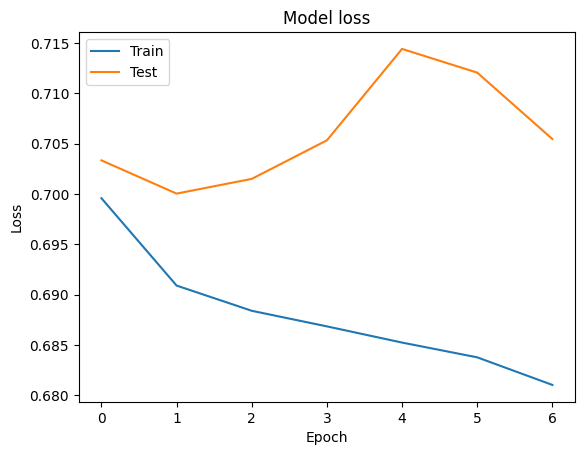

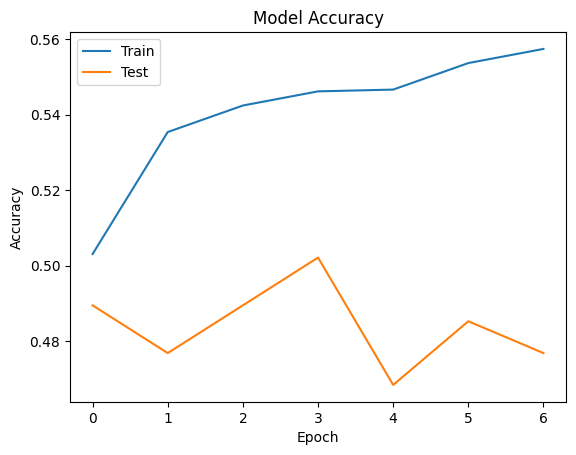

In [177]:
plot_loss_accuracy(history)

### d. Validate Model

In [183]:
model_mae = model.evaluate(X_test, y_test, verbose=0)

print(f'Model Accuracy {model_mae[1]:.4f}')

Model Accuracy 0.5068


### c. Prediction